In [1]:
from torchtext import *
from fastai import *
import torch
from fastai.text import *
from torchtext.datasets import Multi30k, LanguageModelingDataset
from models import *
from torchtext.data import *

In [2]:
URLs

fastai.datasets.URLs

In [2]:
path = untar_data(URLs.HUMAN_NUMBERS)
path.ls()

[PosixPath('/home/louis/.fastai/data/human_numbers/models'),
 PosixPath('/home/louis/.fastai/data/human_numbers/train.txt'),
 PosixPath('/home/louis/.fastai/data/human_numbers/valid.txt')]

In [3]:
lm_ds = LanguageModelingDataset(path/'train.txt', Field(), newline_eos=False)
lm_ds_valid = LanguageModelingDataset(path/'valid.txt', Field(), newline_eos=False)

In [14]:
field = lm_ds.fields['text']

In [4]:
bs = 64
bptt = 50

In [5]:
it = BPTTIterator(lm_ds, bs, bptt)
it_valid = BPTTIterator(lm_ds_valid, bs, bptt)

In [6]:
lm_ds.fields['text'].build_vocab([lm_ds[0].text])
lm_ds_valid.fields['text'].vocab = lm_ds.fields['text'].vocab

In [7]:
def print_matrix(matrix) :
    s=""
    for i in range(len(matrix)) :
        s += "["
        for j in range(len(matrix[0])) :
            s += matrix[i][j] + ", "
        s+= "]\n"
    print(s)

In [8]:
def to_text(x, vocab) :
    
    x_t = x.transpose(0, 1)
    text = [[vocab[x_t[i, j].item()] for j in range(x_t.shape[1])] for i in range(x.shape[0])]
    print_matrix(text)
    
    return text

In [ ]:
counter = 0
for x in it : 
    if counter < 3 :
        to_text(x.text, lm_ds.fields['text'].vocab.itos)
        to_text(x.target, lm_ds.fields['text'].vocab.itos)

In [9]:
def train_epochs(epochs, model, iterator_train, loss_function, optimizer, lr=0.2, iterator_valid = None, show_info=True, **kwargs) :
    
    losses = []
    opt = optimizer(model.parameters(), lr=lr)
    
    model.cuda()
    for i in range(epochs) :
        train_loss = 0
        counter = 0
        accuracy = 0
        model.train()
        for batch in iterator_train :
            x = batch.text
            y = batch.target
            x = x.cuda()
            y = y.cuda()
            pred = model(x.transpose(0,1))
            loss = loss_function(pred, y.transpose(0,1))
            train_loss += loss
            counter += 1
            accuracy += (torch.argmax(pred, dim=2) == y.transpose(0,1)).type(torch.FloatTensor).mean() 
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_loss = train_loss/float(counter)
        accuracy = accuracy/float(counter)
        
        if iterator_valid is not None :
            counter_v = 0

            model.eval()
            valid_loss = 0
            accuracy_valid = 0
            for batch in iterator_valid :
                x = batch.text
                y = batch.target
                x = x.cuda()
                y = y.cuda()
                pred = model(x.transpose(0,1))
                loss = loss_function(pred, y.transpose(0,1))
                valid_loss += loss
                accuracy_valid += (torch.argmax(pred, dim=2) == y.transpose(0,1)).type(torch.FloatTensor).mean() 
                counter_v+= 1
            valid_loss = train_loss/float(counter_v)
            accuracy_valid = accuracy_valid/float(counter_v)
            losses.append(valid_loss)
            if show_info:
                print("Epoch {:.0f} training loss : {:.3f}, train accuracy : {:.3f}, validation loss : {:.3f}, val accuracy : {:.3f}".format(i, train_loss, accuracy, valid_loss, accuracy_valid))
        
        else :
            if show_info :
                print("Epoch {:.0f} training loss : {:.3f}, train accuracy : {:.3f}").format(i, train_loss, accuracy)
    return losses

In [10]:
optimizer = optim.SGD

In [14]:
loss = train_epochs(10, mRNN(100, bs), it, CrossEntropyFlat(), optimizer, iterator_valid=it_valid)

Epoch 0 training loss : 2.576, train accuracy : 0.319, validation loss : 0.644, val accuracy : 0.329
Epoch 1 training loss : 1.968, train accuracy : 0.385, validation loss : 0.492, val accuracy : 0.256
Epoch 2 training loss : 1.795, train accuracy : 0.414, validation loss : 0.449, val accuracy : 0.342
Epoch 3 training loss : 1.670, train accuracy : 0.459, validation loss : 0.418, val accuracy : 0.431
Epoch 4 training loss : 1.537, train accuracy : 0.509, validation loss : 0.384, val accuracy : 0.445
Epoch 5 training loss : 1.372, train accuracy : 0.566, validation loss : 0.343, val accuracy : 0.471
Epoch 6 training loss : 1.224, train accuracy : 0.618, validation loss : 0.306, val accuracy : 0.442
Epoch 7 training loss : 1.110, train accuracy : 0.661, validation loss : 0.278, val accuracy : 0.470
Epoch 8 training loss : 1.002, train accuracy : 0.707, validation loss : 0.251, val accuracy : 0.477
Epoch 9 training loss : 0.929, train accuracy : 0.726, validation loss : 0.232, val accurac

In [13]:
loss = train_epochs(10, mGRU(100, bs), it, CrossEntropyFlat(), optimizer, iterator_valid=it_valid)

Epoch 0 training loss : 2.807, train accuracy : 0.310, validation loss : 0.702, val accuracy : 0.309
Epoch 1 training loss : 2.071, train accuracy : 0.429, validation loss : 0.518, val accuracy : 0.387
Epoch 2 training loss : 1.681, train accuracy : 0.535, validation loss : 0.420, val accuracy : 0.474
Epoch 3 training loss : 1.492, train accuracy : 0.612, validation loss : 0.373, val accuracy : 0.546
Epoch 4 training loss : 1.307, train accuracy : 0.669, validation loss : 0.327, val accuracy : 0.559
Epoch 5 training loss : 1.179, train accuracy : 0.700, validation loss : 0.295, val accuracy : 0.475
Epoch 6 training loss : 1.076, train accuracy : 0.725, validation loss : 0.269, val accuracy : 0.532
Epoch 7 training loss : 0.968, train accuracy : 0.745, validation loss : 0.242, val accuracy : 0.543
Epoch 8 training loss : 0.876, train accuracy : 0.764, validation loss : 0.219, val accuracy : 0.542
Epoch 9 training loss : 0.811, train accuracy : 0.773, validation loss : 0.203, val accurac

In [15]:
train_nbr = 10
epochs = 30

for i in range(train_nbr) :
    avg_m1, avg_m2 = torch.zeros(epochs), torch.zeros(epochs)
    avg_m1 = avg_m1 + (torch.tensor(train_epochs(epochs, mRNN(200, bs), it, CrossEntropyFlat(), optimizer, lr=0.2, iterator_valid=it_valid, show_info=False))/train_nbr)
    avg_m2 = avg_m2 + (torch.tensor(train_epochs(epochs, mGRU(200, bs), it, CrossEntropyFlat(), optimizer, lr=0.2, iterator_valid=it_valid, show_info=False))/train_nbr)
    print(f"train run : {i}")
avg_m1, avg_m2

train run : 0
train run : 1
train run : 2
train run : 3
train run : 4
train run : 5
train run : 6
train run : 7
train run : 8
train run : 9


(tensor([0.0587, 0.0456, 0.0400, 0.0324, 0.0272, 0.0226, 0.0198, 0.0171, 0.0147,
         0.0129, 0.0114, 0.0100, 0.0086, 0.0073, 0.0071, 0.0057, 0.0057, 0.0051,
         0.0044, 0.0041, 0.0038, 0.0036, 0.0048, 0.0063, 0.0032, 0.0029, 0.0027,
         0.0026, 0.0024, 0.0023]),
 tensor([0.0629, 0.0440, 0.0353, 0.0298, 0.0258, 0.0229, 0.0202, 0.0181, 0.0159,
         0.0147, 0.0124, 0.0117, 0.0104, 0.0090, 0.0081, 0.0070, 0.0062, 0.0063,
         0.0052, 0.0047, 0.0044, 0.0040, 0.0039, 0.0037, 0.0035, 0.0033, 0.0032,
         0.0030, 0.0029, 0.0028]))

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

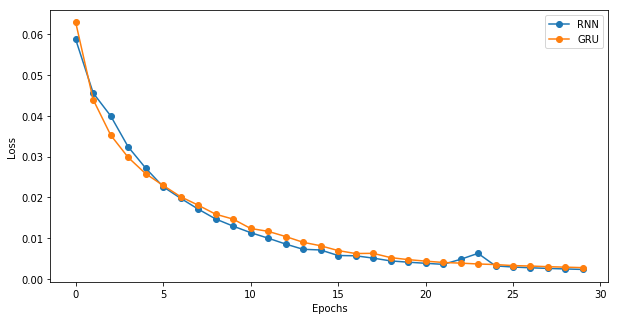

In [18]:
figure(figsize=(10, 5))
plt.plot(range(epochs), avg_m1, marker='o', label='RNN')
plt.plot(range(epochs), avg_m2, marker='o', label='GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
class language_predictor() :
    def __init__(self, language_model, vocab) :
        self.nh = language_model.nh
        self.nv = language_model.nv
        self.i_h = language_model.i_h.cuda() #embedding
        self.cell = language_model.cell.cuda()
        self.h_o = language_model.h_o.cuda()
        self.bn = language_model.bn.cuda()
        self.layers = language_model.layers
        self.bs = 1
        
        
    def predict(self, word, size) :
        word = word.split(' ')
        word_ids = [lm_ds.fields['text'].vocab.stoi[w] for w in word]
        print(word_ids)
        
        h = torch.zeros(self.layers, self.bs, self.nh).cuda()
        x = torch.Tensor([word_ids]).type(torch.LongTensor).cuda()
        
        res, h = self.cell(self.i_h(x), h)
        h = h.detach()
        
        
        x = torch.argmax(nn.Softmax(dim=2)(self.h_o(self.bn(h))), dim=2).type(torch.LongTensor).cuda()
        words = []
        
        for i in range(size) :
            res, h = self.cell(self.i_h(x), h)
            word_id = torch.argmax(nn.Softmax(dim=2)(self.h_o(self.bn(res))), dim=2).type(torch.LongTensor).cuda()
            word = lm_ds.fields['text'].vocab.itos[word_id[0,0].item()]
            words.append(word)
            x = word_id
        return words
    
    def sm_pred(self, word) :
        word = word.split(' ')
        word_ids = [lm_ds.fields['text'].vocab.stoi[w] for w in word]
        print(word_ids)
        
        h = torch.zeros(self.layers, self.bs, self.nh).cuda()
        x = torch.Tensor([word_ids]).type(torch.LongTensor).cuda()        
        
        res, h = self.cell(self.i_h(x), h)
        h = h.detach()
        
        return torch.argmax(nn.Softmax(dim=2)(self.h_o(self.bn(res))), dim=2)

In [174]:
model_t = mGRU(200, bs)

In [175]:
loss = train_epochs(10, model_t, it, CrossEntropyFlat(), optimizer, iterator_valid=it_valid)

Epoch 0 training loss : 2.603, train accuracy : 0.334, validation loss : 0.651, val accuracy : 0.319
Epoch 1 training loss : 1.850, train accuracy : 0.508, validation loss : 0.463, val accuracy : 0.470
Epoch 2 training loss : 1.460, train accuracy : 0.638, validation loss : 0.365, val accuracy : 0.522
Epoch 3 training loss : 1.228, train accuracy : 0.702, validation loss : 0.307, val accuracy : 0.544
Epoch 4 training loss : 1.071, train accuracy : 0.732, validation loss : 0.268, val accuracy : 0.498
Epoch 5 training loss : 0.941, train accuracy : 0.754, validation loss : 0.235, val accuracy : 0.517
Epoch 6 training loss : 0.833, train accuracy : 0.773, validation loss : 0.208, val accuracy : 0.538
Epoch 7 training loss : 0.759, train accuracy : 0.786, validation loss : 0.190, val accuracy : 0.543
Epoch 8 training loss : 0.670, train accuracy : 0.806, validation loss : 0.168, val accuracy : 0.548
Epoch 9 training loss : 0.602, train accuracy : 0.824, validation loss : 0.150, val accurac

In [172]:
def accuracy_over_batches(iterator, model) :
    n_batches = len(iterator)
    accuracy = []
    print(n_batches)
    for x in iterator :
        text = x.text.t().cuda()
        y = x.target.t().cuda()
        res = model_t(text)
        accuracy.append((torch.argmax(nn.Softmax(dim=2)(res), dim=2).type(torch.LongTensor).cuda() == x.target.t().cuda()).type(torch.FloatTensor).mean().item())
    return accuracy

In [187]:
accuracy_over_batches(it, model_t)

14


[0.6534374952316284,
 0.7043750286102295,
 0.7103124856948853,
 0.699999988079071,
 0.7134374976158142,
 0.7143750190734863,
 0.7143750190734863,
 0.7159374952316284,
 0.7065625190734863,
 0.714062511920929,
 0.7074999809265137,
 0.7056249976158142,
 0.715624988079071,
 0.7388392686843872]

In [167]:
torch.argmax(nn.Softmax(dim=2)(res), dim=2).type(torch.LongTensor).cuda()

tensor([[ 6,  2, 20,  ...,  2, 19, 10],
        [ 6,  6,  2,  ...,  4,  5,  2],
        [ 2, 17,  4,  ...,  2, 13,  4],
        ...,
        [ 4,  2, 18,  ...,  5,  2, 17],
        [ 3,  6,  2,  ...,  6,  3,  6],
        [ 4,  7,  3,  ...,  1,  1,  1]], device='cuda:0')

In [161]:
(torch.argmax(nn.Softmax(dim=2)(res), dim=2).type(torch.LongTensor).cuda() == x.target.t().cuda()).type(torch.FloatTensor).mean()

tensor(0.6562)

In [37]:
l_pred = language_predictor(model_t.cuda().eval(), lm_ds.fields['text'].vocab)

In [43]:
res = l_pred.sm_pred('one two three four five six sven')

[6, 10, 9, 5, 4, 8, 0]


In [44]:
res


tensor([[2, 2, 2, 3, 3, 3, 5]], device='cuda:0')

In [29]:
h.detach().shape

torch.Size([2, 1, 200])

In [18]:
x = torch.Tensor([[6, 10, 9, 5]]).type(torch.LongTensor).cuda()

In [19]:
model_t(x)

RuntimeError: Expected hidden size (2, 1, 200), got (2, 64, 200)

In [16]:
field.vocab.stoi

defaultdict(<function torchtext.vocab._default_unk_index()>,
            {'<unk>': 0,
             '<pad>': 1,
             'hundred': 2,
             'thousand': 3,
             'five': 4,
             'four': 5,
             'one': 6,
             'seven': 7,
             'six': 8,
             'three': 9,
             'two': 10,
             'eight': 11,
             'nine': 12,
             'eighty': 13,
             'fifty': 14,
             'forty': 15,
             'ninety': 16,
             'seventy': 17,
             'sixty': 18,
             'thirty': 19,
             'twenty': 20,
             'eighteen': 21,
             'eleven': 22,
             'fifteen': 23,
             'fourteen': 24,
             'nineteen': 25,
             'seventeen': 26,
             'sixteen': 27,
             'ten': 28,
             'thirteen': 29,
             'twelve': 30})

In [31]:
lm_ds.fields['text'].vocab.stoi['one']

6

In [23]:
m = nn.GRU(5, 5, batch_first=True)
emb = nn.Embedding(4,5)

In [15]:
x = torch.Tensor([[[1, 2, 3, 4, 5]]])

In [34]:
yh = m(x, x)[0]
yh

tensor([[[0.4606, 1.2860, 2.3383, 3.9535, 0.2767]]],
       grad_fn=<TransposeBackward0>)

In [29]:
m(emb(torch.argmax(nn.Softmax(dim=2)(yh), dim=2)))

(tensor([[[ 0.5382, -0.0123, -0.0185,  0.0693, -0.1184]]],
        grad_fn=<TransposeBackward0>),
 tensor([[[ 0.5382, -0.0123, -0.0185,  0.0693, -0.1184]]],
        grad_fn=<StackBackward>))

In [40]:
(torch.argmax(nn.Softmax(dim=2)(yh), dim=2)[0, 0]).item()

3